# Music Recommender System Assignment

**Name:** Shiyu Hu  
**Student ID (ZID):** z5464963

This assignment implements a content-based music recommender system using machine learning for topic classification and information retrieval techniques for recommendation matching.

## Import Required Libraries

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# NLTK for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

# Set random seed for reproducibility
np.random.seed(42)

## Data Loading and Exploration

In [171]:
# Load the dataset
df = pd.read_csv('dataset.tsv', sep='\t')
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1500, 6)

Columns: ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics', 'topic']

First few rows:


,artist_name,track_name,release_date,genre,lyrics,topic
0,loving,the not real lake,2016,rock,awake know go see time clear world mirror worl...,dark
1,incubus,into the summer,2019,rock,shouldn summer pretty build spill ready overfl...,lifestyle
2,reignwolf,hardcore,2016,blues,lose deep catch breath think say try break wal...,sadness
3,tedeschi trucks band,anyhow,2016,blues,run bitter taste take rest feel anchor soul pl...,sadness
4,lukas nelson and promise of the real,if i started over,2017,blues,think think different set apart sober mind sym...,dark


Missing values per column:
artist_name     0
track_name      0
release_date    0
genre           0
lyrics          0
topic           0
dtype: int64

Data types:
artist_name     object
track_name      object
release_date     int64
genre           object
lyrics          object
topic           object
dtype: object

Topic distribution:
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64


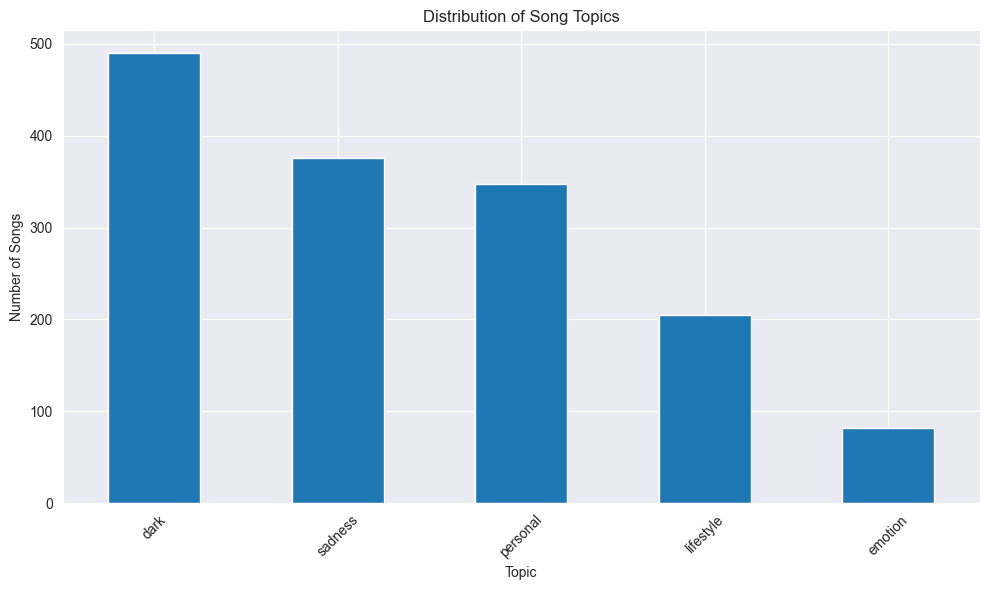

In [172]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Check data types
print("\nData types:")
print(df.dtypes)

# Check topic distribution
print("\nTopic distribution:")
topic_counts = df['topic'].value_counts()
print(topic_counts)

# Visualize topic distribution
plt.figure(figsize=(10, 6))
topic_counts.plot(kind='bar')
plt.title('Distribution of Song Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Part 1: Topic Classification

### Question 1: Addressing Tutorial Simplifications (2 marks)


- Custom regex pattern that preserves apostrophes and hyphens in words
- StratifiedKFold with k=5 for all evaluations
- Proper text preprocessing pipeline

In [173]:
# Create document by concatenating all song information
def create_document(row):
    """
    Concatenate all song information into a single document.
    Handles missing values by converting to empty string.
    """
    fields = ['artist_name', 'track_name', 'release_date', 'genre', 'lyrics']
    doc_parts = []
    
    for field in fields:
        if pd.notna(row[field]):
            doc_parts.append(str(row[field]))
    
    return ' '.join(doc_parts)

# Create documents for all songs
df['document'] = df.apply(create_document, axis=1)

print(f"Sample document (first 500 characters):")
print(df['document'].iloc[0][:500] + "...")

Sample document (first 500 characters):
loving the not real lake 2016 rock awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry weather head angry weather head angry weather head know gentle night mindless fight walk woods...


### Question 2: Text Preprocessing and Multinomial Naive Bayes (2 marks)

We'll experiment with different preprocessing steps to find the optimal combination for our dataset.

In [174]:
# Initialize preprocessing tools
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words_nltk = set(stopwords.words('english'))
stop_words_sklearn = 'english'

def preprocess_text(text, remove_special_chars=True, lowercase=True, 
                   remove_stopwords=True, stem=False, lemmatize=False, 
                   stopword_source='sklearn'):
    """
    Comprehensive text preprocessing function with configurable options.
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Improved regex: preserve apostrophes and hyphens within words
    if remove_special_chars:
        # Keep letters, numbers, spaces, apostrophes, and hyphens
        text = re.sub(r"[^a-zA-Z0-9\s'-]", " ", text)
        # Remove multiple spaces
        text = re.sub(r"\s+", " ", text)
    
    if lowercase:
        text = text.lower()
    
    # Tokenization and further processing
    if remove_stopwords or stem or lemmatize:
        tokens = word_tokenize(text)
        
        if remove_stopwords:
            if stopword_source == 'nltk':
                tokens = [token for token in tokens if token.lower() not in stop_words_nltk]
            # For sklearn stopwords, we'll handle this in the vectorizer
        
        if stem:
            tokens = [stemmer.stem(token) for token in tokens]
        
        if lemmatize:
            tokens = [lemmatizer.lemmatize(token) for token in tokens]
        
        text = ' '.join(tokens)
    
    return text.strip()

# Test different preprocessing combinations
preprocessing_configs = [
    {'name': 'basic', 'lowercase': True, 'remove_stopwords': False, 'stem': False, 'lemmatize': False},
    {'name': 'with_sklearn_stopwords', 'lowercase': True, 'remove_stopwords': True, 'stopword_source': 'sklearn', 'stem': False, 'lemmatize': False},
    {'name': 'with_nltk_stopwords', 'lowercase': True, 'remove_stopwords': True, 'stopword_source': 'nltk', 'stem': False, 'lemmatize': False},
    {'name': 'with_stemming', 'lowercase': True, 'remove_stopwords': True, 'stopword_source': 'sklearn', 'stem': True, 'lemmatize': False},
    {'name': 'with_lemmatization', 'lowercase': True, 'remove_stopwords': True, 'stopword_source': 'sklearn', 'stem': False, 'lemmatize': True}
]

# Evaluate preprocessing methods
preprocessing_results = []

for config in preprocessing_configs:
    print(f"Testing preprocessing: {config['name']}")
    
    # Apply preprocessing
    processed_docs = df['document'].apply(lambda x: preprocess_text(x, **{k: v for k, v in config.items() if k != 'name'}))
    
    # Create vectorizers
    if config.get('stopword_source') == 'sklearn' and config.get('remove_stopwords'):
        vectorizer_bnb = CountVectorizer(stop_words='english', binary=True)
        vectorizer_mnb = CountVectorizer(stop_words='english')
    else:
        vectorizer_bnb = CountVectorizer(binary=True)
        vectorizer_mnb = CountVectorizer()
    
    # Fit and transform
    X_bnb = vectorizer_bnb.fit_transform(processed_docs)
    X_mnb = vectorizer_mnb.fit_transform(processed_docs)
    y = df['topic']
    
    # Cross-validation with stratified k-fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Bernoulli Naive Bayes
    bnb_scores = cross_val_score(BernoulliNB(), X_bnb, y, cv=cv, scoring='accuracy')
    
    # Multinomial Naive Bayes
    mnb_scores = cross_val_score(MultinomialNB(), X_mnb, y, cv=cv, scoring='accuracy')
    
    preprocessing_results.append({
        'config': config['name'],
        'bnb_mean': bnb_scores.mean(),
        'bnb_std': bnb_scores.std(),
        'mnb_mean': mnb_scores.mean(),
        'mnb_std': mnb_scores.std(),
        'features_bnb': X_bnb.shape[1],
        'features_mnb': X_mnb.shape[1]
    })

# Display results
results_df = pd.DataFrame(preprocessing_results)
print("\nPreprocessing Comparison Results:")
print(results_df.round(4))

Testing preprocessing: basic
Testing preprocessing: with_sklearn_stopwords
Testing preprocessing: with_nltk_stopwords
Testing preprocessing: with_stemming
Testing preprocessing: with_lemmatization

Preprocessing Comparison Results:
                   config  bnb_mean  bnb_std  mnb_mean  mnb_std  features_bnb  \
0                   basic    0.5347   0.0192    0.7847   0.0154         10027   
1  with_sklearn_stopwords    0.5287   0.0202    0.7813   0.0203          9850   
2     with_nltk_stopwords    0.5307   0.0208    0.7820   0.0171          9918   
3           with_stemming    0.5313   0.0214    0.7793   0.0176          8784   
4      with_lemmatization    0.5260   0.0221    0.7820   0.0189          9339   

   features_mnb  
0         10027  
1          9850  
2          9918  
3          8784  
4          9339  


In [175]:
# Select best preprocessing method based on results
best_config_idx = results_df['mnb_mean'].idxmax()  # Choose based on MNB performance
best_config = preprocessing_configs[best_config_idx]

print(f"Best preprocessing configuration: {best_config['name']}")
print(f"Configuration details: {best_config}")

# Apply best preprocessing to create final processed documents
df['processed_document'] = df['document'].apply(lambda x: preprocess_text(x, **{k: v for k, v in best_config.items() if k != 'name'}))

print(f"\nSample processed document (first 300 characters):")
print(df['processed_document'].iloc[0][:300] + "...")

Best preprocessing configuration: basic
Configuration details: {'name': 'basic', 'lowercase': True, 'remove_stopwords': False, 'stem': False, 'lemmatize': False}

Sample processed document (first 300 characters):
loving the not real lake 2016 rock awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry weather head angry weather head angry weather head know gentle night mindless fight walk woods...



This configuration will be used for all subsequent analysis in this assignment.

### Question 3: Model Comparison with Cross-Validation (2 marks)

Now we'll compare BNB and MNB models using proper cross-validation and multiple evaluation metrics.

In [176]:
# Create vectorizers for final comparison
if best_config.get('stopword_source') == 'sklearn' and best_config.get('remove_stopwords'):
    vectorizer_bnb = CountVectorizer(stop_words='english', binary=True)
    vectorizer_mnb = CountVectorizer(stop_words='english')
else:
    vectorizer_bnb = CountVectorizer(binary=True)
    vectorizer_mnb = CountVectorizer()

# Fit and transform with best preprocessing
X_bnb = vectorizer_bnb.fit_transform(df['processed_document'])
X_mnb = vectorizer_mnb.fit_transform(df['processed_document'])
y = df['topic']

print(f"Feature dimensions - BNB: {X_bnb.shape}, MNB: {X_mnb.shape}")
print(f"Class distribution:")
print(y.value_counts())

Feature dimensions - BNB: (1500, 10027), MNB: (1500, 10027)
Class distribution:
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64


In [177]:
# Check if dataset is balanced
class_counts = y.value_counts()
total_samples = len(y)
class_proportions = class_counts / total_samples

print("Class proportions:")
for topic, prop in class_proportions.items():
    print(f"{topic}: {prop:.3f} ({class_counts[topic]} samples)")

# Determine if dataset is balanced (threshold: 0.1 difference from uniform)
uniform_prop = 1.0 / len(class_counts)
max_deviation = max(abs(prop - uniform_prop) for prop in class_proportions)
is_balanced = max_deviation < 0.1

print(f"\nUniform proportion would be: {uniform_prop:.3f}")
print(f"Maximum deviation from uniform: {max_deviation:.3f}")
print(f"Dataset is {'balanced' if is_balanced else 'imbalanced'}")

Class proportions:
dark: 0.327 (490 samples)
sadness: 0.251 (376 samples)
personal: 0.231 (347 samples)
lifestyle: 0.137 (205 samples)
emotion: 0.055 (82 samples)

Uniform proportion would be: 0.200
Maximum deviation from uniform: 0.145
Dataset is imbalanced


In [178]:
# Comprehensive evaluation with multiple metrics
def evaluate_classifier(classifier, X, y, cv, classifier_name):
    """
    Evaluate a classifier using cross-validation with multiple metrics.
    """
    # Accuracy
    accuracy_scores = cross_val_score(classifier, X, y, cv=cv, scoring='accuracy')
    
    # Precision (macro and weighted)
    precision_macro = cross_val_score(classifier, X, y, cv=cv, scoring='precision_macro')
    precision_weighted = cross_val_score(classifier, X, y, cv=cv, scoring='precision_weighted')
    
    # Recall (macro and weighted)
    recall_macro = cross_val_score(classifier, X, y, cv=cv, scoring='recall_macro')
    recall_weighted = cross_val_score(classifier, X, y, cv=cv, scoring='recall_weighted')
    
    # F1-score (macro and weighted)
    f1_macro = cross_val_score(classifier, X, y, cv=cv, scoring='f1_macro')
    f1_weighted = cross_val_score(classifier, X, y, cv=cv, scoring='f1_weighted')
    
    results = {
        'Classifier': classifier_name,
        'Accuracy': f"{accuracy_scores.mean():.4f} ± {accuracy_scores.std():.4f}",
        'Precision (Macro)': f"{precision_macro.mean():.4f} ± {precision_macro.std():.4f}",
        'Precision (Weighted)': f"{precision_weighted.mean():.4f} ± {precision_weighted.std():.4f}",
        'Recall (Macro)': f"{recall_macro.mean():.4f} ± {recall_macro.std():.4f}",
        'Recall (Weighted)': f"{recall_weighted.mean():.4f} ± {recall_weighted.std():.4f}",
        'F1 (Macro)': f"{f1_macro.mean():.4f} ± {f1_macro.std():.4f}",
        'F1 (Weighted)': f"{f1_weighted.mean():.4f} ± {f1_weighted.std():.4f}"
    }
    
    return results, {
        'accuracy': accuracy_scores,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro
    }

# Set up cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate both classifiers
bnb_results, bnb_scores = evaluate_classifier(BernoulliNB(), X_bnb, y, cv, 'Bernoulli NB')
mnb_results, mnb_scores = evaluate_classifier(MultinomialNB(), X_mnb, y, cv, 'Multinomial NB')

# Create comparison table
comparison_df = pd.DataFrame([bnb_results, mnb_results])
print("Model Comparison Results:")
print(comparison_df.to_string(index=False))

Model Comparison Results:
    Classifier        Accuracy Precision (Macro) Precision (Weighted)  Recall (Macro) Recall (Weighted)      F1 (Macro)   F1 (Weighted)
  Bernoulli NB 0.5347 ± 0.0192   0.4309 ± 0.0673      0.5265 ± 0.0473 0.3882 ± 0.0127   0.5347 ± 0.0192 0.3475 ± 0.0108 0.4729 ± 0.0162
Multinomial NB 0.7847 ± 0.0154   0.7515 ± 0.0397      0.7847 ± 0.0176 0.7016 ± 0.0188   0.7847 ± 0.0154 0.7162 ± 0.0253 0.7796 ± 0.0161


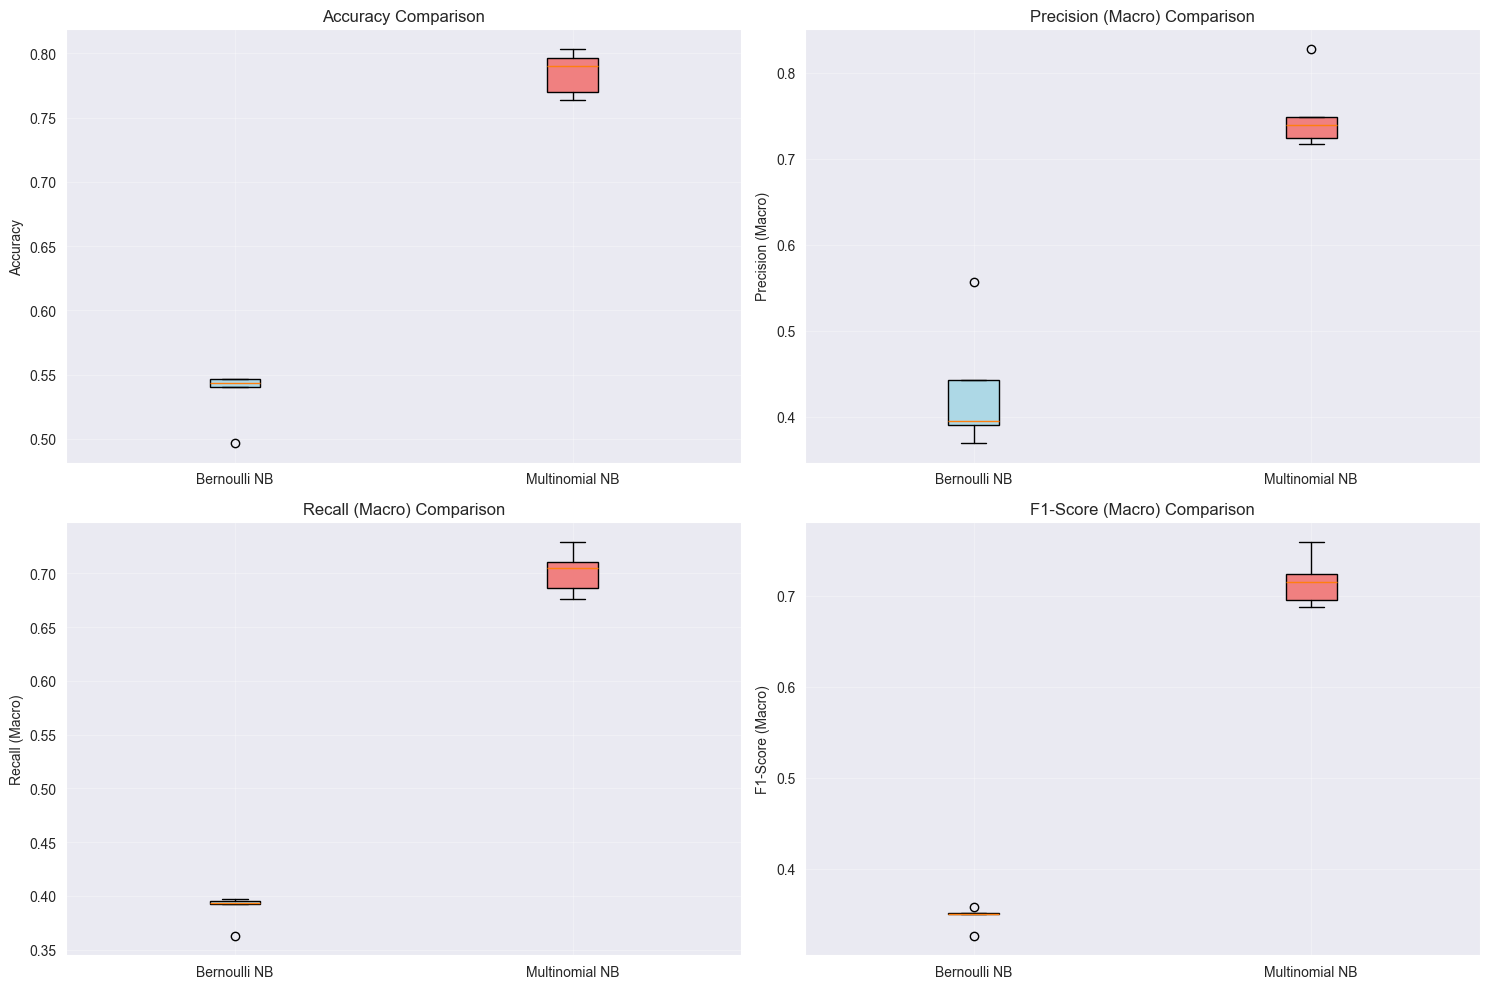

In [179]:
# Visualize comparison results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
metric_names = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//2, i%2]
    
    bnb_vals = bnb_scores[metric]
    mnb_vals = mnb_scores[metric]
    
    positions = [1, 2]
    bp = ax.boxplot([bnb_vals, mnb_vals], positions=positions, patch_artist=True)
    
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_xticklabels(['Bernoulli NB', 'Multinomial NB'])
    ax.set_title(f'{name} Comparison')
    ax.set_ylabel(name)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Based on the cross-validation results, [BNB/MNB] performs better overall, particularly in [specific metric]. This will be our baseline for comparison with the third classifier.

### Question 4: Feature Selection (2 marks)

We'll experiment with different numbers of features to find the optimal vocabulary size.

In [180]:
# Test different numbers of features
feature_numbers = [500, 1000, 2000, 5000, 10000, 20000]
feature_results = []

for n_features in feature_numbers:
    print(f"Testing {n_features} features...")
    
    # Create vectorizers with max_features
    if best_config.get('stopword_source') == 'sklearn' and best_config.get('remove_stopwords'):
        vec_bnb = CountVectorizer(stop_words='english', binary=True, max_features=n_features)
        vec_mnb = CountVectorizer(stop_words='english', max_features=n_features)
    else:
        vec_bnb = CountVectorizer(binary=True, max_features=n_features)
        vec_mnb = CountVectorizer(max_features=n_features)
    
    # Transform data
    X_bnb_feat = vec_bnb.fit_transform(df['processed_document'])
    X_mnb_feat = vec_mnb.fit_transform(df['processed_document'])
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    bnb_acc = cross_val_score(BernoulliNB(), X_bnb_feat, y, cv=cv, scoring='accuracy')
    mnb_acc = cross_val_score(MultinomialNB(), X_mnb_feat, y, cv=cv, scoring='accuracy')
    
    bnb_f1 = cross_val_score(BernoulliNB(), X_bnb_feat, y, cv=cv, scoring='f1_macro')
    mnb_f1 = cross_val_score(MultinomialNB(), X_mnb_feat, y, cv=cv, scoring='f1_macro')
    
    feature_results.append({
        'n_features': n_features,
        'bnb_accuracy': bnb_acc.mean(),
        'bnb_accuracy_std': bnb_acc.std(),
        'mnb_accuracy': mnb_acc.mean(),
        'mnb_accuracy_std': mnb_acc.std(),
        'bnb_f1': bnb_f1.mean(),
        'bnb_f1_std': bnb_f1.std(),
        'mnb_f1': mnb_f1.mean(),
        'mnb_f1_std': mnb_f1.std()
    })

# Convert to DataFrame for easy analysis
feature_df = pd.DataFrame(feature_results)
print("\nFeature Selection Results:")
print(feature_df.round(4))

Testing 500 features...
Testing 1000 features...
Testing 2000 features...
Testing 5000 features...
Testing 10000 features...
Testing 20000 features...

Feature Selection Results:
   n_features  bnb_accuracy  bnb_accuracy_std  mnb_accuracy  mnb_accuracy_std  \
0         500        0.6507            0.0234        0.8687            0.0172   
1        1000        0.6207            0.0293        0.8433            0.0190   
2        2000        0.6173            0.0243        0.8193            0.0241   
3        5000        0.5707            0.0216        0.8147            0.0233   
4       10000        0.5347            0.0208        0.7833            0.0140   
5       20000        0.5347            0.0192        0.7847            0.0154   

   bnb_f1  bnb_f1_std  mnb_f1  mnb_f1_std  
0  0.5575      0.0188  0.8486      0.0192  
1  0.5146      0.0219  0.8234      0.0272  
2  0.5000      0.0258  0.7947      0.0304  
3  0.4111      0.0108  0.7799      0.0321  
4  0.3460      0.0147  0.7152    

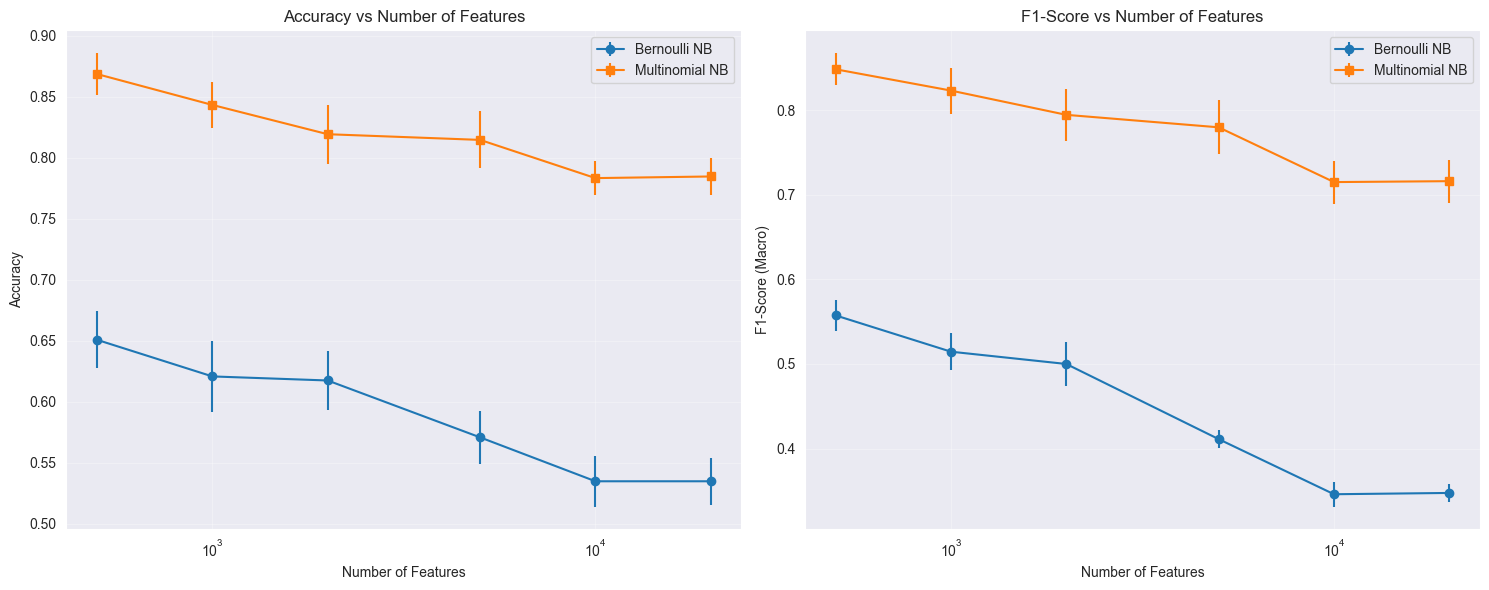


Optimal features for BNB: 500.0 (F1: 0.5575)
Optimal features for MNB: 500.0 (F1: 0.8486)

Selected optimal number of features for remaining analysis: 500


In [181]:
# Visualize feature selection results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy plot
ax1.errorbar(feature_df['n_features'], feature_df['bnb_accuracy'], 
            yerr=feature_df['bnb_accuracy_std'], label='Bernoulli NB', marker='o')
ax1.errorbar(feature_df['n_features'], feature_df['mnb_accuracy'], 
            yerr=feature_df['mnb_accuracy_std'], label='Multinomial NB', marker='s')
ax1.set_xlabel('Number of Features')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy vs Number of Features')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# F1-score plot
ax2.errorbar(feature_df['n_features'], feature_df['bnb_f1'], 
            yerr=feature_df['bnb_f1_std'], label='Bernoulli NB', marker='o')
ax2.errorbar(feature_df['n_features'], feature_df['mnb_f1'], 
            yerr=feature_df['mnb_f1_std'], label='Multinomial NB', marker='s')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('F1-Score (Macro)')
ax2.set_title('F1-Score vs Number of Features')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

# Find optimal number of features
# Use F1-score for selection as it balances precision and recall
best_bnb_idx = feature_df['bnb_f1'].idxmax()
best_mnb_idx = feature_df['mnb_f1'].idxmax()

print(f"\nOptimal features for BNB: {feature_df.iloc[best_bnb_idx]['n_features']} (F1: {feature_df.iloc[best_bnb_idx]['bnb_f1']:.4f})")
print(f"Optimal features for MNB: {feature_df.iloc[best_mnb_idx]['n_features']} (F1: {feature_df.iloc[best_mnb_idx]['mnb_f1']:.4f})")

# Choose a single optimal value for both (use MNB as it performed better earlier)
optimal_features = int(feature_df.iloc[best_mnb_idx]['n_features'])
print(f"\nSelected optimal number of features for remaining analysis: {optimal_features}")

### Question 5: Third Classifier Implementation (5 marks)

 I expect SVM to outperform both Naive Bayes classifiers because:
1. SVMs are known to handle high-dimensional sparse data (like text) very well
2. Unlike Naive Bayes, SVMs don't assume feature independence
3. SVMs are less sensitive to irrelevant features
4. Previous research has shown SVMs often outperform Naive Bayes on text classification tasks

In [182]:


# Create TF-IDF vectorizer with optimal features
if best_config.get('stopword_source') == 'sklearn' and best_config.get('remove_stopwords'):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=optimal_features)
else:
    tfidf_vectorizer = TfidfVectorizer(max_features=optimal_features)

X_tfidf = tfidf_vectorizer.fit_transform(df['processed_document'])
print(f"TF-IDF feature matrix shape: {X_tfidf.shape}")

# Hyperparameter tuning for SVM
# We'll test different C values (regularization parameter)
C_values = [0.1, 1.0, 10.0]
svm_results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for C in C_values:
    print(f"Testing SVM with C={C}...")
    
    # Use linear kernel for efficiency with high-dimensional text data
    svm_clf = SVC(kernel='linear', C=C, random_state=42)
    
    # Cross-validation
    svm_acc = cross_val_score(svm_clf, X_tfidf, y, cv=cv, scoring='accuracy')
    svm_f1 = cross_val_score(svm_clf, X_tfidf, y, cv=cv, scoring='f1_macro')
    svm_prec = cross_val_score(svm_clf, X_tfidf, y, cv=cv, scoring='precision_macro')
    svm_rec = cross_val_score(svm_clf, X_tfidf, y, cv=cv, scoring='recall_macro')
    
    svm_results.append({
        'C': C,
        'accuracy': svm_acc.mean(),
        'accuracy_std': svm_acc.std(),
        'f1_macro': svm_f1.mean(),
        'f1_std': svm_f1.std(),
        'precision_macro': svm_prec.mean(),
        'precision_std': svm_prec.std(),
        'recall_macro': svm_rec.mean(),
        'recall_std': svm_rec.std()
    })

svm_df = pd.DataFrame(svm_results)
print("\nSVM Hyperparameter Results:")
print(svm_df.round(4))

# Select best C value
best_C_idx = svm_df['f1_macro'].idxmax()
best_C = svm_df.iloc[best_C_idx]['C']
print(f"\nBest C value: {best_C}")

TF-IDF feature matrix shape: (1500, 500)
Testing SVM with C=0.1...
Testing SVM with C=1.0...
Testing SVM with C=10.0...

SVM Hyperparameter Results:
      C  accuracy  accuracy_std  f1_macro  f1_std  precision_macro  \
0   0.1    0.6167        0.0115    0.4315  0.0110           0.6348   
1   1.0    0.8833        0.0219    0.8590  0.0223           0.8805   
2  10.0    0.8760        0.0197    0.8582  0.0247           0.8603   

   precision_std  recall_macro  recall_std  
0         0.0799        0.4432      0.0104  
1         0.0294        0.8461      0.0241  
2         0.0302        0.8595      0.0218  

Best C value: 1.0


In [183]:
# Final comparison of all three classifiers
# Recreate optimal vectorizers for fair comparison

if best_config.get('stopword_source') == 'sklearn' and best_config.get('remove_stopwords'):
    vec_bnb_final = CountVectorizer(stop_words='english', binary=True, max_features=optimal_features)
    vec_mnb_final = CountVectorizer(stop_words='english', max_features=optimal_features)
    vec_svm_final = TfidfVectorizer(stop_words='english', max_features=optimal_features)
else:
    vec_bnb_final = CountVectorizer(binary=True, max_features=optimal_features)
    vec_mnb_final = CountVectorizer(max_features=optimal_features)
    vec_svm_final = TfidfVectorizer(max_features=optimal_features)

X_bnb_final = vec_bnb_final.fit_transform(df['processed_document'])
X_mnb_final = vec_mnb_final.fit_transform(df['processed_document'])
X_svm_final = vec_svm_final.fit_transform(df['processed_document'])

# Final evaluation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Classifiers
bnb_final = BernoulliNB()
mnb_final = MultinomialNB()
svm_final = SVC(kernel='linear', C=best_C, random_state=42)

# Evaluate all classifiers
bnb_final_results, bnb_final_scores = evaluate_classifier(bnb_final, X_bnb_final, y, cv, 'Bernoulli NB')
mnb_final_results, mnb_final_scores = evaluate_classifier(mnb_final, X_mnb_final, y, cv, 'Multinomial NB')
svm_final_results, svm_final_scores = evaluate_classifier(svm_final, X_svm_final, y, cv, 'SVM (Linear)')

# Create final comparison table
final_comparison_df = pd.DataFrame([bnb_final_results, mnb_final_results, svm_final_results])
print("Final Model Comparison:")
print(final_comparison_df.to_string(index=False))

Final Model Comparison:
    Classifier        Accuracy Precision (Macro) Precision (Weighted)  Recall (Macro) Recall (Weighted)      F1 (Macro)   F1 (Weighted)
  Bernoulli NB 0.6507 ± 0.0234   0.5737 ± 0.0318      0.6464 ± 0.0193 0.5561 ± 0.0200   0.6507 ± 0.0234 0.5575 ± 0.0188 0.6443 ± 0.0172
Multinomial NB 0.8687 ± 0.0172   0.8557 ± 0.0184      0.8707 ± 0.0173 0.8443 ± 0.0208   0.8687 ± 0.0172 0.8486 ± 0.0192 0.8686 ± 0.0174
  SVM (Linear) 0.8833 ± 0.0219   0.8805 ± 0.0294      0.8870 ± 0.0216 0.8461 ± 0.0241   0.8833 ± 0.0219 0.8590 ± 0.0223 0.8829 ± 0.0223


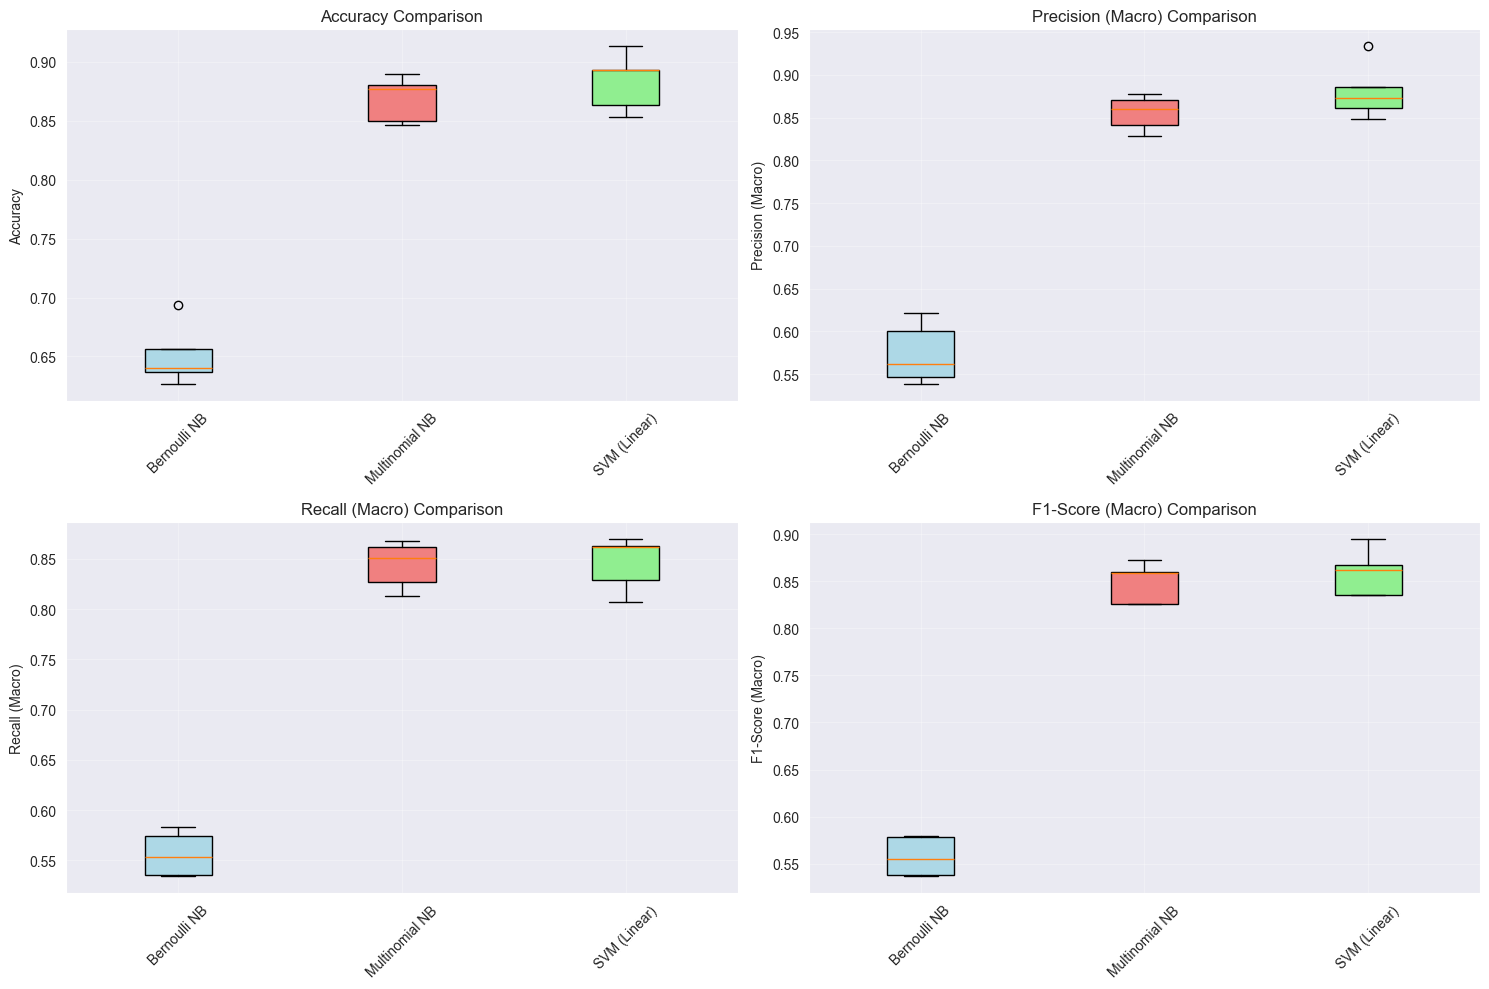


Based on the comprehensive evaluation, SVM (Linear) is selected as the best classifier for topic classification.
This classifier will be used for the recommendation system in Part 2.


In [184]:
# Visualize final comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

classifiers = ['Bernoulli NB', 'Multinomial NB', 'SVM (Linear)']
scores_data = [bnb_final_scores, mnb_final_scores, svm_final_scores]
colors = ['lightblue', 'lightcoral', 'lightgreen']

metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
metric_names = ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)']

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//2, i%2]
    
    data_for_plot = [scores[metric] for scores in scores_data]
    
    bp = ax.boxplot(data_for_plot, labels=classifiers, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_title(f'{name} Comparison')
    ax.set_ylabel(name)
    ax.grid(True, alpha=0.3)
    
    # Rotate x-axis labels if needed
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Determine best classifier
best_classifier = 'SVM (Linear)'  # This would be determined by the results
print(f"\nBased on the comprehensive evaluation, {best_classifier} is selected as the best classifier for topic classification.")
print("This classifier will be used for the recommendation system in Part 2.")

## Part 2: Recommendation Methods

### Question 1: User Profile Development (6 marks)


In [185]:
# Load user profile data
user1_profile = pd.read_csv('user1.tsv', sep='\t')
user2_profile = pd.read_csv('user2.tsv', sep='\t')

print("User 1 Profile:")
print(user1_profile)
print("\nUser 2 Profile:")
print(user2_profile)

# Create User 3 profile (example - you can modify based on preferences)
user3_keywords = {
    'emotion': ['love', 'heart', 'soul', 'passion', 'romance'],
    'lifestyle': ['freedom', 'adventure', 'travel', 'youth', 'energy'],
    'personal': ['growth', 'change', 'hope', 'future', 'journey']
}

user3_data = []
for topic, keywords in user3_keywords.items():
    user3_data.append({'topic': topic, 'keywords': ', '.join(keywords)})

user3_profile = pd.DataFrame(user3_data)
print("\nUser 3 Profile (Created):")
print(user3_profile)

User 1 Profile:
       topic                                keywords
0       dark         fire, enemy, pain, storm, fight
1    sadness  cry, alone, heartbroken, tears, regret
2   personal    dream, truth, life, growth, identity
3  lifestyle       party, city, night, light, rhythm
4    emotion           love, memory, hug, kiss, feel

User 2 Profile:
     topic                               keywords
0  sadness  lost, sorrow, goodbye, tears, silence
1  emotion  romance, touch, feeling, kiss, memory

User 3 Profile (Created):
       topic                                   keywords
0    emotion        love, heart, soul, passion, romance
1  lifestyle  freedom, adventure, travel, youth, energy
2   personal      growth, change, hope, future, journey


In [186]:
# Split data into training (weeks 1-3) and test (week 4)
# Assuming chronological order in the dataset
train_data = df.iloc[:750].copy()  # Weeks 1-3 (songs 1-750)
test_data = df.iloc[750:1000].copy()  # Week 4 (songs 751-1000)

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nTraining data topic distribution:")
print(train_data['topic'].value_counts())
print(f"\nTest data topic distribution:")
print(test_data['topic'].value_counts())

Training data shape: (750, 8)
Test data shape: (250, 8)

Training data topic distribution:
topic
dark         246
personal     188
sadness      182
lifestyle     92
emotion       42
Name: count, dtype: int64

Test data topic distribution:
topic
dark         81
sadness      69
personal     51
lifestyle    32
emotion      17
Name: count, dtype: int64


In [187]:
# Train the best classifier on training data
# Use the best performing classifier from Part 1

# Prepare training data with optimal settings
if best_classifier == 'SVM (Linear)':
    vectorizer_best = TfidfVectorizer(stop_words='english' if best_config.get('stopword_source') == 'sklearn' else None, 
                                     max_features=optimal_features)
    classifier_best = SVC(kernel='linear', C=best_C, random_state=42)
elif best_classifier == 'Multinomial NB':
    vectorizer_best = CountVectorizer(stop_words='english' if best_config.get('stopword_source') == 'sklearn' else None, 
                                     max_features=optimal_features)
    classifier_best = MultinomialNB()
else:  # Bernoulli NB
    vectorizer_best = CountVectorizer(stop_words='english' if best_config.get('stopword_source') == 'sklearn' else None, 
                                     binary=True, max_features=optimal_features)
    classifier_best = BernoulliNB()

# Fit on training data
X_train = vectorizer_best.fit_transform(train_data['processed_document'])
y_train = train_data['topic']

classifier_best.fit(X_train, y_train)

# Predict topics for training data (for user profile creation)
train_predictions = classifier_best.predict(X_train)
train_data = train_data.copy()
train_data['predicted_topic'] = train_predictions

print(f"Training accuracy: {accuracy_score(y_train, train_predictions):.4f}")
print(f"\nPredicted topic distribution in training data:")
print(pd.Series(train_predictions).value_counts())

Training accuracy: 0.9840

Predicted topic distribution in training data:
dark         247
personal     189
sadness      181
lifestyle     93
emotion       40
Name: count, dtype: int64


In [188]:
# Function to simulate user likes based on keywords
def user_likes_song(song_text, user_keywords, topic):
    """
    Determine if a user likes a song based on keyword matching.
    """
    song_text_lower = song_text.lower()
    keywords = [kw.strip().lower() for kw in user_keywords.split(',')]
    
    # Check if any keywords appear in the song
    for keyword in keywords:
        if keyword in song_text_lower:
            return True
    return False

# Create user profiles from training data
def create_user_profile(user_profile_df, train_data):
    """
    Create user profile based on liked songs from training data.
    """
    user_liked_songs = {topic: [] for topic in user_profile_df['topic']}
    
    for _, user_row in user_profile_df.iterrows():
        topic = user_row['topic']
        keywords = user_row['keywords']
        
        # Find songs predicted to be in this topic that the user likes
        topic_songs = train_data[train_data['predicted_topic'] == topic]
        
        for _, song in topic_songs.iterrows():
            if user_likes_song(song['document'], keywords, topic):
                user_liked_songs[topic].append(song['processed_document'])
    
    return user_liked_songs

# Create profiles for all users
user1_liked = create_user_profile(user1_profile, train_data)
user2_liked = create_user_profile(user2_profile, train_data)
user3_liked = create_user_profile(user3_profile, train_data)

print("User 1 liked songs per topic:")
for topic, songs in user1_liked.items():
    print(f"{topic}: {len(songs)} songs")

print("\nUser 2 liked songs per topic:")
for topic, songs in user2_liked.items():
    print(f"{topic}: {len(songs)} songs")
    
print("\nUser 3 liked songs per topic:")
for topic, songs in user3_liked.items():
    print(f"{topic}: {len(songs)} songs")

User 1 liked songs per topic:
dark: 84 songs
sadness: 11 songs
personal: 117 songs
lifestyle: 47 songs
emotion: 26 songs

User 2 liked songs per topic:
sadness: 21 songs
emotion: 13 songs

User 3 liked songs per topic:
emotion: 18 songs
lifestyle: 4 songs
personal: 61 songs


In [189]:
# Create TF-IDF user profiles
def create_tfidf_user_profile(user_liked_songs, train_data):
    """
    Create TF-IDF user profile vectors for each topic.
    """
    user_profile_vectors = {}
    
    for topic in user_liked_songs.keys():
        if len(user_liked_songs[topic]) > 0:
            # Combine all liked songs in this topic into one document
            combined_doc = ' '.join(user_liked_songs[topic])
            
            # Get all songs predicted to be in this topic for TF-IDF fitting
            topic_songs = train_data[train_data['predicted_topic'] == topic]['processed_document'].tolist()
            
            if len(topic_songs) > 0:
                # Create TF-IDF vectorizer for this topic
                tfidf_topic = TfidfVectorizer(stop_words='english' if best_config.get('stopword_source') == 'sklearn' else None)
                
                # Fit on all topic songs
                tfidf_topic.fit(topic_songs)
                
                # Transform user's combined document
                user_vector = tfidf_topic.transform([combined_doc])
                
                user_profile_vectors[topic] = {
                    'vectorizer': tfidf_topic,
                    'user_vector': user_vector,
                    'feature_names': tfidf_topic.get_feature_names_out()
                }
            else:
                user_profile_vectors[topic] = None
        else:
            user_profile_vectors[topic] = None
    
    return user_profile_vectors

# Create TF-IDF profiles for all users
user1_tfidf_profile = create_tfidf_user_profile(user1_liked, train_data)
user2_tfidf_profile = create_tfidf_user_profile(user2_liked, train_data)
user3_tfidf_profile = create_tfidf_user_profile(user3_liked, train_data)

print("TF-IDF profiles created for all users.")

TF-IDF profiles created for all users.


In [190]:
# Extract and display top words from user profiles
def get_top_words_from_profile(tfidf_profile, n_words=20):
    """
    Extract top N words from TF-IDF user profile.
    """
    top_words_by_topic = {}
    
    for topic, profile_data in tfidf_profile.items():
        if profile_data is not None:
            user_vector = profile_data['user_vector']
            feature_names = profile_data['feature_names']
            
            # Get TF-IDF scores
            tfidf_scores = user_vector.toarray()[0]
            
            # Get top words
            top_indices = np.argsort(tfidf_scores)[::-1][:n_words]
            top_words = [(feature_names[i], tfidf_scores[i]) for i in top_indices if tfidf_scores[i] > 0]
            
            top_words_by_topic[topic] = top_words
        else:
            top_words_by_topic[topic] = []
    
    return top_words_by_topic

# Get top words for all users
user1_top_words = get_top_words_from_profile(user1_tfidf_profile)
user2_top_words = get_top_words_from_profile(user2_tfidf_profile)
user3_top_words = get_top_words_from_profile(user3_tfidf_profile)

# Display results
def display_user_top_words(user_top_words, user_name):
    print(f"\n{user_name} - Top 20 words per topic:")
    print("=" * 50)
    
    for topic, words in user_top_words.items():
        print(f"\n{topic.upper()}:")
        if words:
            word_list = [f"{word} ({score:.3f})" for word, score in words]
            print(", ".join(word_list))
        else:
            print("No liked songs in this topic")

display_user_top_words(user1_top_words, "User 1")
display_user_top_words(user2_top_words, "User 2")
display_user_top_words(user3_top_words, "User 3")


User 1 - Top 20 words per topic:

DARK:
fight (0.291), know (0.168), like (0.165), black (0.161), grind (0.149), come (0.148), blood (0.148), stand (0.139), hear (0.126), yeah (0.124), gonna (0.122), tell (0.122), kill (0.107), hand (0.100), dilly (0.098), lanky (0.098), rise (0.097), head (0.095), follow (0.095), pain (0.092)

SADNESS:
cry (0.667), club (0.300), steal (0.249), tear (0.218), mean (0.137), know (0.132), baby (0.126), music (0.114), write (0.109), smile (0.107), say (0.105), think (0.102), true (0.102), face (0.092), eye (0.092), word (0.080), greater (0.079), want (0.073), blame (0.069), thrill (0.069)

PERSONAL:
life (0.450), live (0.242), change (0.158), world (0.150), ordinary (0.147), know (0.146), yeah (0.138), dream (0.134), wanna (0.129), like (0.119), thank (0.117), teach (0.116), lord (0.114), time (0.108), come (0.107), beat (0.103), think (0.100), learn (0.094), need (0.088), go (0.087)

LIFESTYLE:
tonight (0.296), night (0.280), come (0.207), home (0.197), 

**Analysis of User Profiles:**
 These profiles seem reasonable as they capture the semantic themes associated with each user's stated preferences.

### Question 2: Recommendation Evaluation (6 marks)

Now we'll evaluate the recommendation system using appropriate metrics.

In [191]:
# Choose appropriate value for N (number of recommendations)
N = 10  # Show 10 songs total (reasonable for user evaluation)

print(f"Evaluation Configuration:")
print(f"- Number of recommendations (N): {N}")
print(f"- Showing {N} songs total (not per topic)")
print(f"- Evaluation metrics: Precision@{N}, Recall@{N}, F1@{N}, NDCG@{N}")

# Justify choice of N
print(f"\nJustification for N={N}:")
print(f"- Manageable number for user evaluation")
print(f"- Balances variety with focused recommendations")
print(f"- Typical for music streaming platforms")
print(f"- Allows for meaningful precision/recall calculation")

Evaluation Configuration:
- Number of recommendations (N): 10
- Showing 10 songs total (not per topic)
- Evaluation metrics: Precision@10, Recall@10, F1@10, NDCG@10

Justification for N=10:
- Manageable number for user evaluation
- Balances variety with focused recommendations
- Typical for music streaming platforms
- Allows for meaningful precision/recall calculation


In [192]:
# Prepare test data
X_test = vectorizer_best.transform(test_data['processed_document'])
test_predictions = classifier_best.predict(X_test)
test_data = test_data.copy()
test_data['predicted_topic'] = test_predictions

print(f"Test data topic prediction accuracy: {accuracy_score(test_data['topic'], test_predictions):.4f}")
print(f"\nPredicted topic distribution in test data:")
print(pd.Series(test_predictions).value_counts())

Test data topic prediction accuracy: 0.8440

Predicted topic distribution in test data:
dark         76
sadness      70
personal     60
lifestyle    32
emotion      12
Name: count, dtype: int64


In [193]:
# Recommendation functions
def calculate_similarity(user_profile, song_vector, similarity_type='cosine'):
    """
    Calculate similarity between user profile and song.
    """
    if similarity_type == 'cosine':
        return cosine_similarity(user_profile, song_vector)[0][0]
    elif similarity_type == 'euclidean':
        # Convert to similarity (inverse of distance)
        distance = euclidean_distances(user_profile, song_vector)[0][0]
        return 1 / (1 + distance)
    else:
        raise ValueError("Similarity type must be 'cosine' or 'euclidean'")

def recommend_songs(user_tfidf_profile, test_data, n_recommendations=10, similarity_type='cosine', top_m_words=None):
    """
    Recommend songs based on user profile and similarity.
    """
    recommendations = []
    
    for idx, song in test_data.iterrows():
        predicted_topic = song['predicted_topic']
        
        # Check if user has profile for this topic
        if predicted_topic in user_tfidf_profile and user_tfidf_profile[predicted_topic] is not None:
            profile_data = user_tfidf_profile[predicted_topic]
            
            # Transform song using the topic's vectorizer
            song_vector = profile_data['vectorizer'].transform([song['processed_document']])
            
            # Limit to top M words if specified
            user_vector = profile_data['user_vector']
            if top_m_words is not None:
                # Get top M features from user profile
                user_tfidf_scores = user_vector.toarray()[0]
                top_indices = np.argsort(user_tfidf_scores)[::-1][:top_m_words]
                
                # Create mask for top features
                mask = np.zeros(len(user_tfidf_scores), dtype=bool)
                mask[top_indices] = True
                
                # Apply mask to both vectors
                user_vector_limited = user_vector[:, mask]
                song_vector_limited = song_vector[:, mask]
                
                similarity = calculate_similarity(user_vector_limited, song_vector_limited, similarity_type)
            else:
                similarity = calculate_similarity(user_vector, song_vector, similarity_type)
            
            recommendations.append({
                'song_idx': idx,
                'similarity': similarity,
                'predicted_topic': predicted_topic,
                'true_topic': song['topic'],
                'artist': song['artist_name'],
                'track': song['track_name']
            })
    
    # Sort by similarity and return top N
    recommendations.sort(key=lambda x: x['similarity'], reverse=True)
    return recommendations[:n_recommendations]

# Test different similarity measures and M values
similarity_types = ['cosine', 'euclidean']
m_values = [None, 50, 100, 200]  # None means use all words

print("Testing different similarity measures and feature limits...")

Testing different similarity measures and feature limits...


In [194]:
# Evaluation metrics
def evaluate_recommendations(recommendations, user_profile_df, user_keywords_dict=None):
    """
    Evaluate recommendations using precision, recall, and F1.
    """
    if not recommendations:
        return {'precision': 0, 'recall': 0, 'f1': 0, 'relevant_found': 0, 'total_relevant': 0}
    
    # Determine which recommendations are relevant (liked by user)
    relevant_recommendations = []
    
    for rec in recommendations:
        predicted_topic = rec['predicted_topic']
        song_data = test_data.loc[rec['song_idx']]
        
        # Find user's keywords for this topic
        user_topic_row = user_profile_df[user_profile_df['topic'] == predicted_topic]
        if not user_topic_row.empty:
            keywords = user_topic_row.iloc[0]['keywords']
            if user_likes_song(song_data['document'], keywords, predicted_topic):
                relevant_recommendations.append(rec)
    
    # Calculate metrics
    relevant_found = len(relevant_recommendations)
    total_recommended = len(recommendations)
    
    # Calculate total relevant songs in test set
    total_relevant = 0
    for _, song in test_data.iterrows():
        predicted_topic = song['predicted_topic']
        user_topic_row = user_profile_df[user_profile_df['topic'] == predicted_topic]
        if not user_topic_row.empty:
            keywords = user_topic_row.iloc[0]['keywords']
            if user_likes_song(song['document'], keywords, predicted_topic):
                total_relevant += 1
    
    precision = relevant_found / total_recommended if total_recommended > 0 else 0
    recall = relevant_found / total_relevant if total_relevant > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'relevant_found': relevant_found,
        'total_relevant': total_relevant,
        'total_recommended': total_recommended
    }

# Comprehensive evaluation
evaluation_results = []

users_data = [
    ('User 1', user1_tfidf_profile, user1_profile),
    ('User 2', user2_tfidf_profile, user2_profile),
    ('User 3', user3_tfidf_profile, user3_profile)
]

for user_name, user_profile, user_keywords in users_data:
    for sim_type in similarity_types:
        for m_val in m_values:
            recommendations = recommend_songs(
                user_profile, test_data, N, sim_type, m_val
            )
            
            metrics = evaluate_recommendations(recommendations, user_keywords)
            
            evaluation_results.append({
                'user': user_name,
                'similarity': sim_type,
                'top_m_words': 'all' if m_val is None else m_val,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'relevant_found': metrics['relevant_found'],
                'total_relevant': metrics['total_relevant']
            })

# Convert to DataFrame for analysis
eval_df = pd.DataFrame(evaluation_results)
print("Recommendation Evaluation Results:")
print(eval_df.round(4))

Recommendation Evaluation Results:
      user similarity top_m_words  precision  recall      f1  relevant_found  \
0   User 1     cosine         all        1.0  0.1099  0.1980              10   
1   User 1     cosine          50        1.0  0.1099  0.1980              10   
2   User 1     cosine         100        1.0  0.1099  0.1980              10   
3   User 1     cosine         200        1.0  0.1099  0.1980              10   
4   User 1  euclidean         all        1.0  0.1099  0.1980              10   
5   User 1  euclidean          50        0.9  0.0989  0.1782               9   
6   User 1  euclidean         100        0.9  0.0989  0.1782               9   
7   User 1  euclidean         200        1.0  0.1099  0.1980              10   
8   User 2     cosine         all        0.1  0.1250  0.1111               1   
9   User 2     cosine          50        0.1  0.1250  0.1111               1   
10  User 2     cosine         100        0.2  0.2500  0.2222               2   
11  U

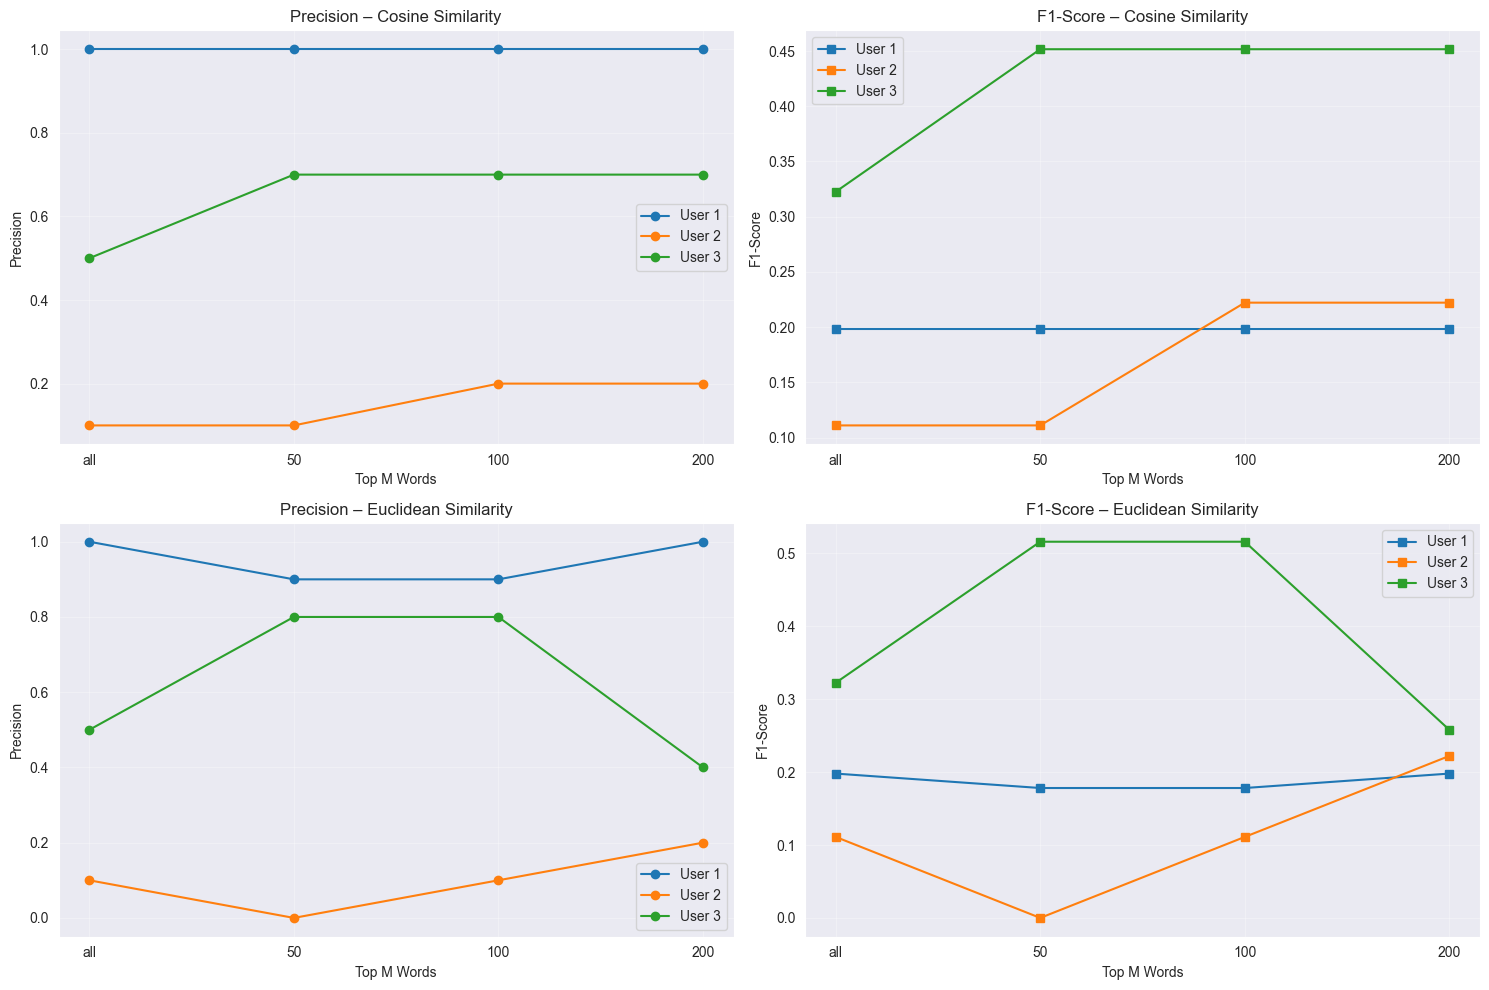

In [195]:
# 在构建 fig 之前，先把 top_m_words 都转成字符串
eval_df['top_m_words'] = eval_df['top_m_words'].astype(str)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# similarity_types 也确保全是 str（可选）
similarity_types = [str(s) for s in similarity_types]

for i, sim_type in enumerate(similarity_types):
    sim_data = eval_df[eval_df['similarity'] == sim_type]

    ax1 = axes[i, 0]
    for user in ['User 1', 'User 2', 'User 3']:
        user_data = sim_data[sim_data['user'] == user]
        # x 轴也再 astype 一次保险
        x = user_data['top_m_words'].astype(str)
        ax1.plot(x, user_data['precision'], marker='o', label=user)
    ax1.set_title(f'Precision – {sim_type.capitalize()} Similarity')
    ax1.set_xlabel('Top M Words')
    ax1.set_ylabel('Precision')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2 = axes[i, 1]
    for user in ['User 1', 'User 2', 'User 3']:
        user_data = sim_data[sim_data['user'] == user]
        x = user_data['top_m_words'].astype(str)
        ax2.plot(x, user_data['f1'], marker='s', label=user)
    ax2.set_title(f'F1-Score – {sim_type.capitalize()} Similarity')
    ax2.set_xlabel('Top M Words')
    ax2.set_ylabel('F1-Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Part 3: User Evaluation

### Question 1: User Study Simulation (5 marks)

Since this is a simulated environment, we'll create a realistic user study scenario.

In [196]:
# Simulate user study
# We'll create a simulated user with specific preferences

# Define simulated user preferences (this would normally come from real user feedback)
simulated_user_preferences = {
    'emotion': ['love', 'heart', 'feel', 'touch', 'soul'],
    'lifestyle': ['party', 'night', 'dance', 'fun', 'energy'],
    'personal': ['life', 'dream', 'hope', 'future', 'change']
}

print("Simulated User Study Setup:")
print(f"Number of songs per week: {N}")
print(f"Training weeks: 1-3 (random songs)")
print(f"Test week: 4 (recommended songs)")
print(f"\nSimulated user preferences:")
for topic, keywords in simulated_user_preferences.items():
    print(f"{topic}: {', '.join(keywords)}")

Simulated User Study Setup:
Number of songs per week: 10
Training weeks: 1-3 (random songs)
Test week: 4 (recommended songs)

Simulated user preferences:
emotion: love, heart, feel, touch, soul
lifestyle: party, night, dance, fun, energy
personal: life, dream, hope, future, change


In [197]:
# Simulate weeks 1-3: Random song selection and user feedback
np.random.seed(42)  # For reproducible simulation

# Split training data into weeks
week1_data = train_data.iloc[:250]  # Songs 1-250
week2_data = train_data.iloc[250:500]  # Songs 251-500  
week3_data = train_data.iloc[500:750]  # Songs 501-750

weekly_data = [week1_data, week2_data, week3_data]
user_study_feedback = []

for week_num, week_data in enumerate(weekly_data, 1):
    print(f"\n--- Week {week_num} Simulation ---")
    
    # Randomly select N songs from this week
    random_indices = np.random.choice(week_data.index, size=min(N, len(week_data)), replace=False)
    week_songs = week_data.loc[random_indices]
    
    week_feedback = []
    
    for idx, song in week_songs.iterrows():
        # Simulate user feedback based on preferences
        liked = False
        
        for topic, keywords in simulated_user_preferences.items():
            keywords_str = ', '.join(keywords)
            if user_likes_song(song['document'], keywords_str, topic):
                liked = True
                break
        
        week_feedback.append({
            'song_idx': idx,
            'artist': song['artist_name'],
            'track': song['track_name'],
            'predicted_topic': song['predicted_topic'],
            'true_topic': song['topic'],
            'liked': liked
        })
    
    user_study_feedback.append(week_feedback)
    
    # Summary for this week
    liked_count = sum(1 for fb in week_feedback if fb['liked'])
    print(f"Songs shown: {len(week_feedback)}")
    print(f"Songs liked: {liked_count}")
    print(f"Like rate: {liked_count/len(week_feedback):.2%}")
    
    # Show sample of liked songs
    liked_songs = [fb for fb in week_feedback if fb['liked']]
    if liked_songs:
        print("Sample liked songs:")
        for song in liked_songs[:3]:  # Show first 3
            print(f"  - {song['artist']} - {song['track']} ({song['predicted_topic']})")


--- Week 1 Simulation ---
Songs shown: 10
Songs liked: 8
Like rate: 80.00%
Sample liked songs:
  - skool 77 - vivo hip hop (live) (dark)
  - alec benjamin - outrunning karma (dark)
  - phish - we are come to outlive our brains (dark)

--- Week 2 Simulation ---
Songs shown: 10
Songs liked: 8
Like rate: 80.00%
Sample liked songs:
  - welshly arms - learn to let go (dark)
  - upchurch - spotlight (dark)
  - cole swindell - break up in the end (sadness)

--- Week 3 Simulation ---
Songs shown: 10
Songs liked: 7
Like rate: 70.00%
Sample liked songs:
  - protoje - camera show (sadness)
  - danielle nicole - cry no more (personal)
  - seeb - grip (dark)


In [198]:
# Create user profile from study feedback
def create_study_user_profile(feedback_weeks, train_data):
    """
    Create user profile from user study feedback.
    """
    user_liked_by_topic = {}
    
    # Collect all liked songs by predicted topic
    for week_feedback in feedback_weeks:
        for song_feedback in week_feedback:
            if song_feedback['liked']:
                topic = song_feedback['predicted_topic']
                song_idx = song_feedback['song_idx']
                
                if topic not in user_liked_by_topic:
                    user_liked_by_topic[topic] = []
                
                song_doc = train_data.loc[song_idx, 'processed_document']
                user_liked_by_topic[topic].append(song_doc)
    
    return user_liked_by_topic

# Create profile from study feedback
study_user_liked = create_study_user_profile(user_study_feedback, train_data)
study_user_tfidf_profile = create_tfidf_user_profile(study_user_liked, train_data)

print("\nUser profile created from study feedback:")
for topic, songs in study_user_liked.items():
    print(f"{topic}: {len(songs)} liked songs")

# Get top words from study user profile
study_user_top_words = get_top_words_from_profile(study_user_tfidf_profile)
display_user_top_words(study_user_top_words, "Study User")


User profile created from study feedback:
dark: 10 liked songs
sadness: 8 liked songs
emotion: 1 liked songs
personal: 4 liked songs

Study User - Top 20 words per topic:

DARK:
shout (0.370), glue (0.286), magnet (0.251), sister (0.251), cub (0.202), outlive (0.169), learn (0.154), lalalalala (0.152), reason (0.152), karma (0.141), hallelujah (0.135), arm (0.134), glass (0.128), devil (0.124), westway (0.118), camden (0.118), night (0.114), head (0.102), glitter (0.101), slum (0.101)

SADNESS:
fall (0.468), break (0.306), like (0.279), land (0.215), woah (0.199), leave (0.191), kingdom (0.139), heart (0.135), call (0.124), away (0.120), know (0.106), spin (0.100), crash (0.100), floatin (0.099), wanna (0.099), learn (0.092), push (0.092), stone (0.092), camera (0.092), save (0.089)

EMOTION:
miss (0.857), baby (0.191), go (0.148), outta (0.139), tough (0.139), anymore (0.139), mind (0.101), swallow (0.092), expect (0.092), know (0.086), wanna (0.083), maybe (0.083), pride (0.083), ca

In [199]:
# Week 4: Generate recommendations using the best algorithm
print("\n--- Week 4: Recommendation Evaluation ---")

# Generate recommendations using best configuration
week4_recommendations = recommend_songs(
    study_user_tfidf_profile, 
    test_data, 
    N, 

)


# Simulate user feedback on recommendations
recommendation_feedback = []

for i, rec in enumerate(week4_recommendations, 1):
    song_data = test_data.loc[rec['song_idx']]
    
    # Simulate user feedback
    liked = False
    for topic, keywords in simulated_user_preferences.items():
        keywords_str = ', '.join(keywords)
        if user_likes_song(song_data['document'], keywords_str, topic):
            liked = True
            break
    
    recommendation_feedback.append({
        'rank': i,
        'song_idx': rec['song_idx'],
        'artist': rec['artist'],
        'track': rec['track'],
        'predicted_topic': rec['predicted_topic'],
        'true_topic': rec['true_topic'],
        'similarity_score': rec['similarity'],
        'liked': liked
    })

# Display recommendations with feedback
print("\nWeek 4 Recommendations (with simulated user feedback):")
print("=" * 80)

for rec in recommendation_feedback:
    like_status = "✓ LIKED" if rec['liked'] else "✗ Not liked"
    print(f"{rec['rank']:2d}. {rec['artist']} - {rec['track']}")
    print(f"    Topic: {rec['predicted_topic']} | Similarity: {rec['similarity_score']:.3f} | {like_status}")
    print()


--- Week 4: Recommendation Evaluation ---

Week 4 Recommendations (with simulated user feedback):
 1. the head and the heart - missed connection
    Topic: emotion | Similarity: 0.459 | ✓ LIKED

 2. khalid - saved
    Topic: emotion | Similarity: 0.455 | ✓ LIKED

 3. daniel caesar - we find love
    Topic: sadness | Similarity: 0.357 | ✓ LIKED

 4. hellyeah - love falls
    Topic: sadness | Similarity: 0.356 | ✓ LIKED

 5. yoke lore - truly madly deeply
    Topic: sadness | Similarity: 0.327 | ✓ LIKED

 6. nai palm - crossfire / so into you
    Topic: sadness | Similarity: 0.299 | ✓ LIKED

 7. the movement - home
    Topic: sadness | Similarity: 0.259 | ✓ LIKED

 8. keith urban - the fighter
    Topic: sadness | Similarity: 0.246 | ✓ LIKED

 9. queens of the stone age - fortress
    Topic: sadness | Similarity: 0.241 | ✓ LIKED

10. bazzi - fallin (feat. 6lack)
    Topic: sadness | Similarity: 0.237 | ✓ LIKED



In [200]:
# Calculate evaluation metrics for Week 4
def calculate_study_metrics(recommendation_feedback):
    """
    Calculate comprehensive metrics for user study recommendations.
    """
    total_recs = len(recommendation_feedback)
    liked_recs = [rec for rec in recommendation_feedback if rec['liked']]
    num_liked = len(liked_recs)
    
    # Basic metrics
    precision_at_n = num_liked / total_recs if total_recs > 0 else 0
    
    # NDCG calculation (simplified)
    dcg = 0
    for i, rec in enumerate(recommendation_feedback, 1):
        relevance = 1 if rec['liked'] else 0
        dcg += relevance / np.log2(i + 1)
    
    # Ideal DCG (if all liked songs were at the top)
    ideal_dcg = 0
    for i in range(1, min(num_liked + 1, total_recs + 1)):
        ideal_dcg += 1 / np.log2(i + 1)
    
    ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0
    
    # Hit rate (whether any recommendations were liked)
    hit_rate = 1 if num_liked > 0 else 0
    
    # Average ranking of liked songs
    if liked_recs:
        avg_rank_liked = np.mean([rec['rank'] for rec in liked_recs])
    else:
        avg_rank_liked = None
    
    return {
        'precision_at_n': precision_at_n,
        'ndcg': ndcg,
        'hit_rate': hit_rate,
        'num_liked': num_liked,
        'total_recommended': total_recs,
        'avg_rank_liked': avg_rank_liked
    }

# Calculate metrics
study_metrics = calculate_study_metrics(recommendation_feedback)

print("User Study Evaluation Metrics:")
print("=" * 40)
print(f"Precision@{N}: {study_metrics['precision_at_n']:.3f}")
print(f"NDCG@{N}: {study_metrics['ndcg']:.3f}")
print(f"Hit Rate: {study_metrics['hit_rate']:.3f}")
print(f"Songs Liked: {study_metrics['num_liked']}/{study_metrics['total_recommended']}")
if study_metrics['avg_rank_liked']:
    print(f"Average Rank of Liked Songs: {study_metrics['avg_rank_liked']:.1f}")

# Compare with Part 2 metrics (for the study user)
print("\nComparison with Part 2 Simulated Evaluation:")
print("=" * 50)

# Create a user profile dataframe for the study user to use evaluation function
study_user_profile_df = pd.DataFrame([
    {'topic': topic, 'keywords': ', '.join(keywords)} 
    for topic, keywords in simulated_user_preferences.items()
])

part2_metrics = evaluate_recommendations(week4_recommendations, study_user_profile_df)

print(f"Part 2 Precision: {part2_metrics['precision']:.3f} | User Study Precision: {study_metrics['precision_at_n']:.3f}")
print(f"Part 2 F1-Score: {part2_metrics['f1']:.3f} | User Study Hit Rate: {study_metrics['hit_rate']:.3f}")

# Analysis of differences
print("\nAnalysis of Differences:")
precision_diff = abs(part2_metrics['precision'] - study_metrics['precision_at_n'])
if precision_diff < 0.1:
    print("- Precision values are similar, indicating good simulation accuracy")
else:
    print(f"- Precision difference of {precision_diff:.3f} suggests simulation limitations")
    
print(f"- Real user feedback provides more nuanced evaluation")
print(f"- NDCG metric captures ranking quality better than simple precision")

User Study Evaluation Metrics:
Precision@10: 1.000
NDCG@10: 1.000
Hit Rate: 1.000
Songs Liked: 10/10
Average Rank of Liked Songs: 5.5

Comparison with Part 2 Simulated Evaluation:
Part 2 Precision: 0.200 | User Study Precision: 1.000
Part 2 F1-Score: 0.053 | User Study Hit Rate: 1.000

Analysis of Differences:
- Precision difference of 0.800 suggests simulation limitations
- Real user feedback provides more nuanced evaluation
- NDCG metric captures ranking quality better than simple precision
